In [3]:
import numpy as np
import gym
from scipy.linalg import hadamard
import matplotlib.pyplot as plt
import sklearn.preprocessing
from matplotlib import animation
from scipy.optimize import linprog


class ESMethods:
    def __init__(self, envName, stateDim, actionDim, actionIsDiscrete):
        self.n = stateDim
        self.m = actionDim
        self.envName = envName
        self.actionIsDiscrete = actionIsDiscrete
        if self.envName == 'MountainCarContinuous-v0':
            self.generateNormalizer()
        
    def generateNormalizer(self):
        env = gym.make(self.envName)
        state_space_samples = np.array(
            [env.observation_space.sample() for x in range(10000)])
        self.scaler = sklearn.preprocessing.StandardScaler()
        self.scaler.fit(state_space_samples)    
    
    def policy_func(self, state, weights):

        '''
        weights[0] A is n*m, weights[1] b is 1*m
        n is dimension of s, m is dimension of action
            For example, in CartPole task, n of observation is 4, m of action is 2
        '''
        if self.envName == 'MountainCarContinuous-v0':
            state = self.scaler.transform([state])
            
        A = weights[0]
        b = weights[1]
        if self.actionIsDiscrete:
            return np.argmax(np.dot(state, A) + b)
        else:
            #print(state.shape,A.shape,b.shape,(np.dot(state, A) + b)[0].shape)
            return (np.dot(state, A) + b)[0]

    def reward_func(self, state, reward):
        if self.envName == 'MountainCarContinuous-v0':
#             if state[0] > 0.4:
#                 reward += 40
#             elif state[0] > 0.2:
#                 reward += 20
#             elif state[0] > -0.2:
#                 reward += 10
            reward += 1*(state[0]+0.6)**2

        return reward
        
    # control variate term mechanisms
    def vanilla(self, env, paras, gaussian_samples, sample_size, step_size, sigma, total_rewards):
        for g_sample in gaussian_samples:
            perturbed_paras = paras + sigma * g_sample
            #         perturbed_weights = [perturbed_paras[:n*m].reshape((n,m)),perturbed_paras[-m:].reshape(1,m)]
            perturbed_weights = [perturbed_paras[:self.n * self.m].reshape((self.n, self.m)),
                                 perturbed_paras[self.n * self.m:self.n * self.m + self.m].reshape(1,
                                                                                                   self.m)]

            # search F, the total reward
            total_reward = self.search_reward(env, perturbed_weights, step_size)

            total_rewards.append(total_reward)
        
        # estimate gradient according to Gaussian Smoothing Lemma
        gaussian_smoothing_gradient = (1 / (sigma * sample_size)) * sum(
            [total_rewards[i] * gaussian_samples[i] for i in range(sample_size)])
        return gaussian_smoothing_gradient
    
    def antithetic(self,env,paras,gaussian_samples,sample_size,step_size,sigma,total_rewards):
        total_rewards_diff = []
        for g_sample in gaussian_samples:
            perturbed_paras = paras+sigma*g_sample
            perturbed_weights = [perturbed_paras[:self.n * self.m].reshape((self.n, self.m)),
                                 perturbed_paras[self.n * self.m:self.n * self.m + self.m].reshape(1,
                                                                                                   self.m)]

            # search F, the total reward
            total_reward = self.search_reward(env,perturbed_weights,step_size)

            # antithtic sample
            perturbed_paras_anti = paras+(-sigma)*g_sample
            perturbed_weights_anti = [perturbed_paras_anti[:self.n * self.m].reshape((self.n, self.m)),
                                 perturbed_paras_anti[self.n * self.m:self.n * self.m + self.m].reshape(1,
                                                                                                   self.m)]

            # search F, the total reward
            total_reward_anti = self.search_reward(env,perturbed_weights_anti,step_size)

            total_rewards.append((total_reward+total_reward_anti)/2)
            total_rewards_diff.append(total_reward-total_reward_anti)

        # estimate gradient according to Gaussian Smoothing Lemma
        gaussian_smoothing_gradient = (1/(2*sigma*sample_size))*sum([total_rewards_diff[i]*gaussian_samples[i] for i in range(sample_size)])
        return gaussian_smoothing_gradient
    
    def forward_fd(self,env,paras,gaussian_samples,sample_size,step_size,sigma,total_rewards):
        total_rewards_diff = []
        base_weights = [paras[:self.n * self.m].reshape((self.n, self.m)),
                                 paras[self.n * self.m:self.n * self.m + self.m].reshape(1,
                                                                                                   self.m)]
        total_reward_orgin = self.search_reward(env,base_weights,step_size)
        for g_sample in gaussian_samples:
            perturbed_paras = paras+sigma*g_sample
            perturbed_weights = [perturbed_paras[:self.n * self.m].reshape((self.n, self.m)),
                                 perturbed_paras[self.n * self.m:self.n * self.m + self.m].reshape(1,
                                                                                                   self.m)]

            # search F, the total reward
            total_reward = self.search_reward(env,perturbed_weights,step_size)

            total_rewards.append(total_reward)

        # estimate gradient according to Gaussian Smoothing Lemma
        gaussian_smoothing_gradient = (1/(2*sigma*sample_size))*sum([(total_rewards[i]-total_reward_orgin)*gaussian_samples[i] for i in range(sample_size)])
        return gaussian_smoothing_gradient

    def regression_basd_ridge(self,env,paras,gaussian_samples,sample_size,step_size,sigma,total_rewards,alpha=0.1): 
        base_weights = [paras[:self.n * self.m].reshape((self.n, self.m)),
                                 paras[self.n * self.m:self.n * self.m + self.m].reshape(1,
                                                                                                   self.m)]
        total_reward_orgin = self.search_reward(env,base_weights,step_size)
        for g_sample in gaussian_samples:
            perturbed_paras = paras+sigma*g_sample
            perturbed_weights = [perturbed_paras[:self.n * self.m].reshape((self.n, self.m)),
                                 perturbed_paras[self.n * self.m:self.n * self.m + self.m].reshape(1,
                                                                                                   self.m)]

            # search F, the total reward
            total_reward = self.search_reward(env,perturbed_weights,step_size)

            total_rewards.append(total_reward)

        # estimate gradient according to Gaussian Smoothing Lemma
        Y=[(total_rewards[i]-total_reward_orgin)/sigma for i in range(sample_size)]
        ridge=Ridge(alpha=alpha)
        ridge.fit(gaussian_samples,Y)
        regression_ridge_gradient=ridge.coef_
        return regression_ridge_gradient
    
    def regression_basd_lasso(self,env,paras,gaussian_samples,sample_size,step_size,sigma,total_rewards,alpha=0.1): 
        base_weights = [paras[:self.n * self.m].reshape((self.n, self.m)),
                                 paras[self.n * self.m:self.n * self.m + self.m].reshape(1,
                                                                                                   self.m)]
        total_reward_orgin = self.search_reward(env,base_weights,step_size)
        for g_sample in gaussian_samples:
            perturbed_paras = paras+sigma*g_sample
            perturbed_weights = [perturbed_paras[:self.n * self.m].reshape((self.n, self.m)),
                                 perturbed_paras[self.n * self.m:self.n * self.m + self.m].reshape(1,
                                                                                                   self.m)]

            # search F, the total reward
            total_reward = self.search_reward(env,perturbed_weights,step_size)

            total_rewards.append(total_reward)

        # estimate gradient according to Gaussian Smoothing Lemma
        Y=[(total_rewards[i]-total_reward_orgin)/sigma for i in range(sample_size)]
        lasso=Lasso(alpha=alpha)
        lasso.fit(gaussian_samples,Y)
        regression_lasso_gradient=lasso.coef_
        return regression_lasso_gradient
    
    def regression_basd_LP(self,env,paras,gaussian_samples,sample_size,step_size,sigma,total_rewards,alpha=0.1): 
        base_weights = [paras[:self.n * self.m].reshape((self.n, self.m)),
                                 paras[self.n * self.m:self.n * self.m + self.m].reshape(1,
                                                                                                   self.m)]
        total_reward_orgin = self.search_reward(env,base_weights,step_size)
        for g_sample in gaussian_samples:
            perturbed_paras = paras+sigma*g_sample
            perturbed_weights = [perturbed_paras[:self.n * self.m].reshape((self.n, self.m)),
                                 perturbed_paras[self.n * self.m:self.n * self.m + self.m].reshape(1,
                                                                                                   self.m)]

            # search F, the total reward
            total_reward = self.search_reward(env,perturbed_weights,step_size)

            total_rewards.append(total_reward)

        # estimate gradient according to Gaussian Smoothing Lemma
        Y=[(total_rewards[i]-total_reward_orgin)/sigma for i in range(sample_size)]
        C = np.ones(sample_size+len(paras))
        C[sample_size:]=0
        A_ub=np.zeros((2*sample_size,sample_size+len(paras)))
        for i in range(sample_size):
            for j in range(sample_size):
                if i==j:
                    A_ub[i,j]=-1
                    A_ub[i+sample_size,j]=-1
        for i in range(sample_size):
            for j in range(len(paras)):
                A_ub[i,j+sample_size]=-gaussian_samples[i][j]
        for i in range(sample_size):
            for j in range(len(paras)):
                A_ub[i+sample_size,j+sample_size]=gaussian_samples[i][j]
        b_ub=np.zeros(2*sample_size)
        for i in range(sample_size):
            b_ub[i]=-Y[i]
        for i in range(sample_size):
            b_ub[i+sample_size]=Y[i]
        Bounds=tuple([(0,None) for i in range(sample_size)]+[(None,None) for i in range(len(paras))])
        r = linprog(C,A_ub,b_ub,bounds=Bounds)
        regression_LP_gradient = r.x[sample_size:]
        return regression_LP_gradient    

    
    # sampling methods
    # with samples chosen independently
    def gaussian_sampling(self, base_paras, sample_size):
        return [np.random.normal(loc=0, scale=1, size=base_paras.shape) for i in range(sample_size)]
    
    def givens_random_rotation(self,base_paras, sample_size):
        sample_paras = []
        for sample in range(sample_size):
            angle = np.random.rand() * 2 * np.pi
            rank = len(base_paras)
            paras_index = np.arange(rank)
            np.random.shuffle(paras_index)
            i, j = paras_index[:2]
            givens_rotation_matrix = np.zeros([rank, rank])
            givens_rotation_matrix[range(rank), range(rank)] = 1
            givens_rotation_matrix[i, i] = np.cos(angle)
            givens_rotation_matrix[j, j] = np.cos(angle)
            givens_rotation_matrix[i, j] = np.sin(angle)
            givens_rotation_matrix[j, i] = -np.sin(angle)
            sample_paras.append(np.dot(givens_rotation_matrix, base_paras))
        #print(sample_paras)
        return sample_paras
    
    def givens_random_rotation_new(self,base_paras, sample_size):
        sample_paras = []
        for sample in range(sample_size):
            angle = np.random.rand() * 2 * np.pi
            rank = len(base_paras)
            paras_index = np.arange(rank)
            np.random.shuffle(paras_index)
            i, j = paras_index[:2]
            givens_rotation_matrix = np.zeros([rank, rank])
            givens_rotation_matrix[range(rank), range(rank)] = 1
            givens_rotation_matrix[i, i] = np.cos(angle)
            givens_rotation_matrix[j, j] = np.cos(angle)
            givens_rotation_matrix[i, j] = np.sin(angle)
            givens_rotation_matrix[j, i] = -np.sin(angle)
            new_paras = np.random.normal(loc=0,scale=1,size=base_paras.shape)
            sample_paras.append(np.dot(givens_rotation_matrix, new_paras))
        return sample_paras
    
    
    def gaussian_orthogonal_matrices_sampling(self,base_paras,sample_size):
    
        def Gram_Schmidt_Orthogonalization(base_paras,sample_size):
            # assumption: sample_size<=paras_num
            gaussian_samples = [np.random.randn(base_paras.shape[0]) for i in range(sample_size)]
            orthogonal_gaussian_samples = np.zeros_like(gaussian_samples)
            for i,alpha in enumerate(gaussian_samples):
                beta = np.copy(alpha)
                for beta_i in orthogonal_gaussian_samples[:i]:
                    beta -= np.dot(alpha,beta_i.T)*beta_i
                orthogonal_gaussian_samples[i] = beta/np.sqrt(np.dot(beta,beta.T))

                # renormalization
                orthogonal_gaussian_samples[i] = orthogonal_gaussian_samples[i]*np.sqrt(np.dot(alpha,alpha.T))

            return orthogonal_gaussian_samples

        if sample_size>len(base_paras):
            # Gram-Schmidt Orthogonalization Assumption not met
            # According to the paper, when N>d, each consecutive set of d vectors is conditioned to be orthogonal almost-surely, with distinct sets of d vectors remaining independent.
            d = len(base_paras)
            i = 0
            gaussian_orthogonal_matrices = np.zeros((sample_size,len(base_paras)))
            while i*d<sample_size:
                gaussian_orthogonal_matrices[i*d:min((i+1)*d,sample_size)] = Gram_Schmidt_Orthogonalization(base_paras,min(d,sample_size-i*d))
                i += 1
        else:
            gaussian_orthogonal_matrices = Gram_Schmidt_Orthogonalization(base_paras,sample_size)

        return gaussian_orthogonal_matrices

    def random_Hadamard_matrices_sampling(self, base_paras, sample_size=None, k=3):
        d = base_paras.shape[0]
        l = 2 ** int(np.ceil(np.log2(d)))
        M = np.eye(l)
        H = hadamard(l)
        for _ in range(k):
            D = np.diag([np.random.choice([-1, 1]) for _ in range(l)])
            HD = (1 / np.sqrt(l)) * np.matmul(H, D)
#             HD = np.matmul(H, D)
            M = np.matmul(M, HD)

        return [np.array(x) for x in M]

    def search_reward(self, env, perturbed_weights, step_size):
        total_reward = 0

        state = env.reset()  # return initial state

        for _ in range(step_size):
            action = self.policy_func(state, perturbed_weights)
            if not self.actionIsDiscrete:
                if action>env.action_space.high:
                    action=env.action_space.high
                elif action<env.action_space.low:
                    action=env.action_space.low
            state, reward, done, info = env.step(action)
            total_reward += reward
#             total_reward += self.reward_func(state, reward)
            if done:
                break
        return total_reward

    # simulation for each step of optimization
    def one_step_optimize(self, env, paras, gaussian_samples, sample_size, control_variate_func, step_size=500, sigma=1,
                          learning_rate=0.1):
        total_rewards = []

        gaussian_smoothing_gradient = control_variate_func(env, paras, gaussian_samples, sample_size, step_size, sigma,
                                                           total_rewards)

        # update parameters
        new_paras = paras + learning_rate * gaussian_smoothing_gradient

        return new_paras, np.mean(total_rewards)

    def optimization(self, env, paras, control_variate_func, sampling_func, step_size=200, sample_size=50, sigma=1,
                     learning_rate=0.1, echos=50):
        new_paras = paras
        avg_reward_list = []
        sample_nums_list = []
        for e in range(1, echos + 1):
            # gaussian sampling, assume σ=1
            gaussian_samples = sampling_func(new_paras, sample_size)
            new_paras, avg_reward = self.one_step_optimize(env, new_paras, gaussian_samples, sample_size,
                                                           control_variate_func, step_size, sigma, learning_rate)
            avg_reward_list.append(avg_reward)
            sample_nums_list.append(e * sample_size)
            if e == 1 or e % 10 == 0:
                print('Echo %d completed, avg_reward %f' % (e, avg_reward))

        return new_paras, avg_reward_list, sample_nums_list

    def trainModel(self, control_variate_name='vanilla', sampling_func_name='gaussian_sampling', step_size=200,
                   sample_size=50, sigma=1, learning_rate=0.1, echos=50):
        env = gym.make(self.envName)

        control_variate_func = {'vanilla': self.vanilla,
                                'antithetic': self.antithetic,
                                'forward_fd':self.forward_fd,
                                'regression_basd_ridge': self.regression_basd_ridge,
                                'regression_basd_lasso': self.regression_basd_lasso,
                                'regression_basd_LP': self.regression_basd_LP
                               }.get(control_variate_name)
        sampling_func = {'gaussian_sampling': self.gaussian_sampling,
                         'gaussian_orthogonal_matrices_sampling':self.gaussian_orthogonal_matrices_sampling,
                         'random_Hadamard_matrices_sampling': self.random_Hadamard_matrices_sampling,
                         'givens_random_rotation':self.givens_random_rotation,
                         'givens_random_rotation_new':self.givens_random_rotation_new
                        }.get(
            sampling_func_name)

        if sampling_func_name == 'random_Hadamard_matrices_sampling':
            l = 2 ** int(np.ceil(np.log2((self.n + 1) * self.m)))
            initial_paras = np.random.rand(l)
            sample_size = l
            self.trainedParas, avg_reward_list, sample_nums_list = self.optimization(env, initial_paras,
                                                                                     control_variate_func,
                                                                                     sampling_func, sample_size=sample_size,
                                                                                     step_size=step_size, sigma=sigma,
                                                                                     learning_rate=learning_rate,
                                                                                     echos=echos)
        else:
            initial_paras = np.random.rand((self.n + 1) * self.m)
            self.trainedParas, avg_reward_list, sample_nums_list = self.optimization(env, initial_paras,
                                                                                     control_variate_func,
                                                                                     sampling_func,
                                                                                     sample_size=sample_size,
                                                                                     step_size=step_size, sigma=sigma,
                                                                                     learning_rate=learning_rate,
                                                                                     echos=echos)

        env.close()
        plt.plot(sample_nums_list, avg_reward_list)
        plt.title('%s (sample size=%d, iterations=%d)' % (self.envName, sample_size, echos))
        plt.xlabel('Total Number of Samples')
        plt.ylabel('Average Rewards')
        
#         return (sample_nums_list, avg_reward_list)

    def testModel(self, steps=500, repeat_num = 5, isShow=0, isSave=0):
        env = gym.make(self.envName)
        total_reward = []
        for i in range(repeat_num):
            try:
                new_weights = [self.trainedParas[:self.n * self.m].reshape((self.n, self.m)),
                               self.trainedParas[self.n * self.m:self.n * self.m + self.m].reshape(1, self.m)]
            except AttributeError:
                print('Error! Please train model before test!')
                return

            observation = env.reset()
            r = 0
            frames = []

            for _ in range(steps):
                if isShow:
                    if isSave:
                        frames.append(env.render(mode="rgb_array"))
                    else:
                        env.render()

                action = self.policy_func(observation, new_weights)
                if not self.actionIsDiscrete:
                    if action>env.action_space.high:
                        action=env.action_space.high
                    elif action<env.action_space.low:
                        action=env.action_space.low

                observation, reward, done, info = env.step(action)
                r += reward
                if done:
                    print('Finish in %d steps'%_)
                    break       
            total_reward.append(r)
            
            env.close()
            #print('Total Rewards:', r)
            if isShow and isSave:
                self.save_frames_as_gif(frames)
        
        print('The rewards for',repeat_num,'attemps is:',total_reward)
        print('The average reward for',repeat_num,'attemps is:',np.array(total_reward).mean())
        print('The standard deviation for',repeat_num,'attemps is:',np.array(total_reward).std())            
            
    
    def save_frames_as_gif(self, frames):
        plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)

        patch = plt.imshow(frames[0])
        plt.axis('off')

        def animate(i):
            patch.set_data(frames[i])

        anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
        anim.save(self.envName+'.gif', writer='imagemagick', fps=60)

    
    

## CartPole-v0

    'gaussian_sampling'
    'gaussian_orthogonal_matrices_sampling'
    'random_Hadamard_matrices_sampling'
    'givens_random_rotation'
    'givens_random_rotation_new'

In [4]:
obj = ESMethods('CartPole-v0', 4, 2, 1)

Echo 1 completed, avg_reward 13.420000
Echo 10 completed, avg_reward 198.990000
Echo 20 completed, avg_reward 200.000000
Echo 30 completed, avg_reward 200.000000
Echo 40 completed, avg_reward 200.000000
Echo 50 completed, avg_reward 199.720000


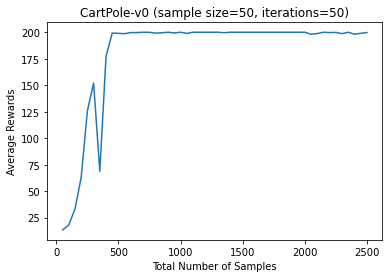

In [5]:
obj.trainModel('antithetic', 'gaussian_sampling',step_size=500)

In [6]:
obj.testModel(steps=500, isSave=0 )

Finish in 199 steps
Finish in 199 steps
Finish in 199 steps
Finish in 199 steps
Finish in 199 steps
The rewards for 5 attemps is: [200.0, 200.0, 200.0, 200.0, 200.0]
The average reward for 5 attemps is: 200.0
The standard deviation for 5 attemps is: 0.0


Echo 1 completed, avg_reward 10.560000
Echo 10 completed, avg_reward 33.030000
Echo 20 completed, avg_reward 200.000000
Echo 30 completed, avg_reward 200.000000
Echo 40 completed, avg_reward 200.000000
Echo 50 completed, avg_reward 200.000000


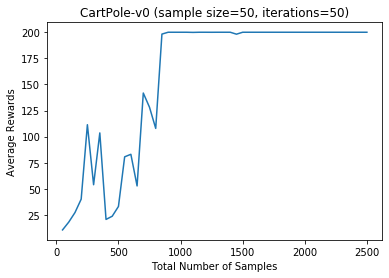

In [89]:
obj.trainModel('antithetic', 'gaussian_orthogonal_matrices_sampling',step_size=500)

In [90]:
obj.testModel(steps=500, isSave=0)

Finish in 199 steps
Finish in 199 steps
Finish in 199 steps
Finish in 199 steps
Finish in 199 steps
The rewards for 5 attemps is: [200.0, 200.0, 200.0, 200.0, 200.0]
The average reward for 5 attemps is: 200.0
The standard deviation for 5 attemps is: 0.0


Echo 1 completed, avg_reward 20.937500
Echo 10 completed, avg_reward 189.843750
Echo 20 completed, avg_reward 199.187500
Echo 30 completed, avg_reward 197.375000
Echo 40 completed, avg_reward 200.000000
Echo 50 completed, avg_reward 200.000000


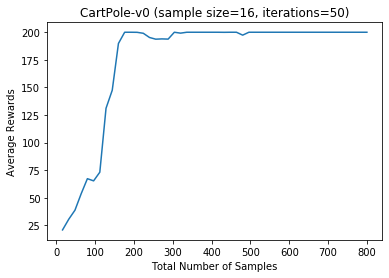

In [91]:
obj.trainModel('antithetic', 'random_Hadamard_matrices_sampling',step_size=500)

In [92]:
obj.testModel(steps=500, isSave=0)

Finish in 199 steps
Finish in 199 steps
Finish in 199 steps
Finish in 199 steps
Finish in 199 steps
The rewards for 5 attemps is: [200.0, 200.0, 200.0, 200.0, 200.0]
The average reward for 5 attemps is: 200.0
The standard deviation for 5 attemps is: 0.0


Echo 1 completed, avg_reward 12.680000
Echo 10 completed, avg_reward 187.000000
Echo 20 completed, avg_reward 200.000000
Echo 30 completed, avg_reward 199.620000
Echo 40 completed, avg_reward 200.000000
Echo 50 completed, avg_reward 200.000000


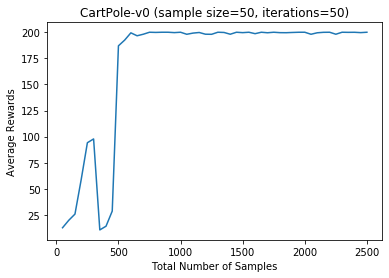

In [93]:
obj.trainModel('antithetic', 'givens_random_rotation_new',step_size=500)

In [94]:
obj.testModel(steps=500, isSave=0)

Finish in 199 steps
Finish in 199 steps
Finish in 199 steps
Finish in 199 steps
Finish in 199 steps
The rewards for 5 attemps is: [200.0, 200.0, 200.0, 200.0, 200.0]
The average reward for 5 attemps is: 200.0
The standard deviation for 5 attemps is: 0.0


## MountainCarContinuous

In [7]:
obj = ESMethods('MountainCarContinuous-v0', 2, 1, 0)

Echo 1 completed, avg_reward 3.320718
Echo 10 completed, avg_reward 91.448418
Echo 20 completed, avg_reward 91.629589
Echo 30 completed, avg_reward 91.581337
Echo 40 completed, avg_reward 92.313070
Echo 50 completed, avg_reward 89.315572


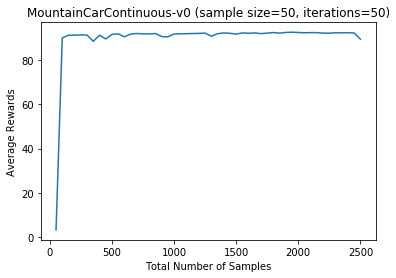

In [96]:
obj.trainModel('antithetic', 'gaussian_sampling', step_size=500)

In [99]:
obj.testModel(steps=500, isSave=0, repeat_num = 30)

Finish in 70 steps
Finish in 70 steps
Finish in 70 steps
Finish in 70 steps
Finish in 70 steps
Finish in 98 steps
Finish in 74 steps
Finish in 70 steps
Finish in 98 steps
Finish in 70 steps
Finish in 77 steps
Finish in 99 steps
Finish in 98 steps
Finish in 70 steps
Finish in 70 steps
Finish in 103 steps
Finish in 98 steps
Finish in 70 steps
Finish in 70 steps
Finish in 99 steps
Finish in 70 steps
Finish in 98 steps
Finish in 99 steps
Finish in 70 steps
Finish in 70 steps
Finish in 102 steps
Finish in 70 steps
Finish in 73 steps
Finish in 70 steps
Finish in 70 steps
The rewards for 30 attemps is: [93.55183232596679, 93.46317525677887, 93.36328404063936, 93.3027425111172, 93.30095434027507, 90.89821161349137, 93.65428160112947, 93.59717163530152, 90.69099135943159, 93.48866898472741, 93.69135262440521, 90.97682264974571, 90.89460261003956, 93.3170687294537, 93.4615377406573, 91.09264724049542, 90.80521538012403, 93.39334994473903, 93.2756228225401, 90.84128467031155, 93.35648354163953, 9

Echo 1 completed, avg_reward 11.963831
Echo 10 completed, avg_reward 91.848120
Echo 20 completed, avg_reward 91.923167
Echo 30 completed, avg_reward 91.819592
Echo 40 completed, avg_reward 92.338280
Echo 50 completed, avg_reward 92.300366


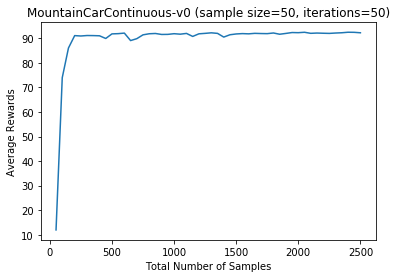

In [101]:
obj.trainModel('antithetic', 'gaussian_orthogonal_matrices_sampling',step_size=500)

In [102]:
obj.testModel(steps=500, isSave=0, repeat_num = 30)

Finish in 70 steps
Finish in 71 steps
Finish in 71 steps
Finish in 77 steps
Finish in 72 steps
Finish in 72 steps
Finish in 70 steps
Finish in 71 steps
Finish in 76 steps
Finish in 70 steps
Finish in 86 steps
Finish in 70 steps
Finish in 74 steps
Finish in 70 steps
Finish in 71 steps
Finish in 70 steps
Finish in 70 steps
Finish in 71 steps
Finish in 70 steps
Finish in 71 steps
Finish in 72 steps
Finish in 71 steps
Finish in 70 steps
Finish in 70 steps
Finish in 72 steps
Finish in 104 steps
Finish in 70 steps
Finish in 70 steps
Finish in 71 steps
Finish in 70 steps
The rewards for 30 attemps is: [93.28549678679161, 93.39356030286858, 93.33203920177274, 93.60614209379307, 93.03548661287843, 93.02955195049458, 93.37862754126269, 93.42810464284996, 93.57241711101089, 93.35170300273953, 93.7291939184628, 93.23861666317119, 93.42064901703662, 93.24944822456591, 93.14315360731631, 93.2668774332559, 93.30173481994899, 93.14275919341125, 93.34992804953735, 93.13810910403629, 93.04144120044268, 

Echo 1 completed, avg_reward 17.419312
Echo 10 completed, avg_reward 92.143001
Echo 20 completed, avg_reward 92.384074
Echo 30 completed, avg_reward 92.733818
Echo 40 completed, avg_reward 92.620340
Echo 50 completed, avg_reward 91.577571


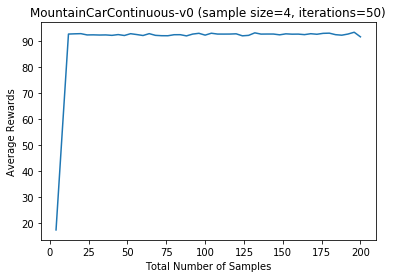

In [103]:
obj.trainModel('antithetic', 'random_Hadamard_matrices_sampling',step_size=500)

In [104]:
obj.testModel(steps=500, isSave=0, repeat_num = 30)

Finish in 153 steps
Finish in 75 steps
Finish in 76 steps
Finish in 76 steps
Finish in 75 steps
Finish in 77 steps
Finish in 76 steps
Finish in 75 steps
Finish in 75 steps
Finish in 76 steps
Finish in 75 steps
Finish in 75 steps
Finish in 76 steps
Finish in 86 steps
Finish in 80 steps
Finish in 80 steps
Finish in 76 steps
Finish in 79 steps
Finish in 75 steps
Finish in 75 steps
Finish in 75 steps
Finish in 75 steps
Finish in 75 steps
Finish in 76 steps
Finish in 75 steps
Finish in 76 steps
Finish in 76 steps
Finish in 152 steps
Finish in 75 steps
Finish in 97 steps
The rewards for 30 attemps is: [89.73203139917155, 93.31204136998954, 93.08782348776778, 93.08648001991342, 93.37076835876266, 92.98976095157023, 93.35209569571147, 93.2144690375533, 93.2540360562223, 93.35142941581054, 93.2172760013175, 92.85844341827263, 93.40840204875025, 93.52452132218318, 93.48950123746538, 93.43749703764591, 93.47664103623914, 93.48168203341918, 93.28375495583788, 93.23492787733079, 93.20557678385393, 

Echo 1 completed, avg_reward 26.263902
Echo 10 completed, avg_reward 88.554565
Echo 20 completed, avg_reward 91.642582
Echo 30 completed, avg_reward 92.353384
Echo 40 completed, avg_reward 92.106934
Echo 50 completed, avg_reward 92.289436


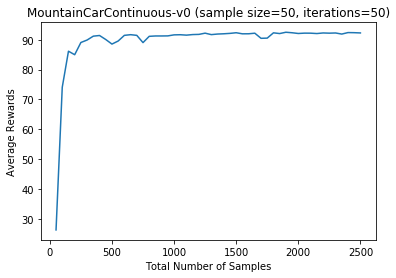

In [105]:
obj.trainModel('antithetic', 'givens_random_rotation_new',step_size=500)

In [106]:
obj.testModel(steps=500, isSave=0, repeat_num = 30)

Finish in 71 steps
Finish in 71 steps
Finish in 74 steps
Finish in 71 steps
Finish in 74 steps
Finish in 73 steps
Finish in 71 steps
Finish in 73 steps
Finish in 71 steps
Finish in 71 steps
Finish in 73 steps
Finish in 73 steps
Finish in 72 steps
Finish in 71 steps
Finish in 73 steps
Finish in 72 steps
Finish in 71 steps
Finish in 72 steps
Finish in 72 steps
Finish in 71 steps
Finish in 74 steps
Finish in 71 steps
Finish in 73 steps
Finish in 73 steps
Finish in 74 steps
Finish in 72 steps
Finish in 72 steps
Finish in 72 steps
Finish in 71 steps
Finish in 73 steps
The rewards for 30 attemps is: [93.16444988087925, 93.1918701086228, 92.85647123648313, 93.18292263408172, 92.85637236574502, 92.95038123801729, 93.16867973055479, 92.95332739520441, 93.22950833495369, 93.19571385839163, 93.16168469949119, 92.95242591506643, 93.05207109272826, 93.2219893579339, 92.95010316809602, 93.04867049647274, 93.16229247945444, 93.23589503260548, 93.05079443753819, 93.16901967025679, 92.85649663113135, 9

## Acrobot

In [10]:
obj = ESMethods('Acrobot-v1', 6, 3, 1)

Echo 1 completed, avg_reward -417.380000
Echo 10 completed, avg_reward -86.290000
Echo 20 completed, avg_reward -85.130000
Echo 30 completed, avg_reward -84.660000
Echo 40 completed, avg_reward -89.050000
Echo 50 completed, avg_reward -83.770000


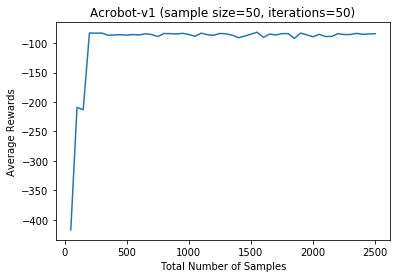

In [129]:
obj.trainModel('antithetic', 'gaussian_sampling',step_size=500)

In [130]:
obj.testModel(steps=500, isSave=0, repeat_num = 30)

Finish in 92 steps
Finish in 72 steps
Finish in 85 steps
Finish in 78 steps
Finish in 79 steps
Finish in 84 steps
Finish in 78 steps
Finish in 77 steps
Finish in 64 steps
Finish in 78 steps
Finish in 99 steps
Finish in 73 steps
Finish in 114 steps
Finish in 89 steps
Finish in 97 steps
Finish in 82 steps
Finish in 86 steps
Finish in 73 steps
Finish in 78 steps
Finish in 86 steps
Finish in 85 steps
Finish in 76 steps
Finish in 85 steps
Finish in 65 steps
Finish in 77 steps
Finish in 80 steps
Finish in 80 steps
Finish in 72 steps
Finish in 85 steps
Finish in 78 steps
The rewards for 30 attemps is: [-92.0, -72.0, -85.0, -78.0, -79.0, -84.0, -78.0, -77.0, -64.0, -78.0, -99.0, -73.0, -114.0, -89.0, -97.0, -82.0, -86.0, -73.0, -78.0, -86.0, -85.0, -76.0, -85.0, -65.0, -77.0, -80.0, -80.0, -72.0, -85.0, -78.0]
The average reward for 30 attemps is: -81.56666666666666
The standard deviation for 30 attemps is: 9.851170263250735


Echo 1 completed, avg_reward -433.440000
Echo 10 completed, avg_reward -91.040000
Echo 20 completed, avg_reward -84.320000
Echo 30 completed, avg_reward -83.640000
Echo 40 completed, avg_reward -84.250000
Echo 50 completed, avg_reward -82.450000


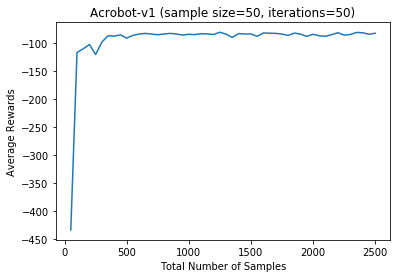

In [131]:
obj.trainModel('antithetic', 'gaussian_orthogonal_matrices_sampling',step_size=500)

In [132]:
obj.testModel(steps=500, isSave=0, repeat_num = 30)

Finish in 71 steps
Finish in 72 steps
Finish in 77 steps
Finish in 69 steps
Finish in 80 steps
Finish in 77 steps
Finish in 79 steps
Finish in 92 steps
Finish in 113 steps
Finish in 78 steps
Finish in 71 steps
Finish in 80 steps
Finish in 97 steps
Finish in 70 steps
Finish in 83 steps
Finish in 263 steps
Finish in 79 steps
Finish in 286 steps
Finish in 108 steps
Finish in 113 steps
Finish in 69 steps
Finish in 75 steps
Finish in 63 steps
Finish in 77 steps
Finish in 71 steps
Finish in 85 steps
Finish in 77 steps
Finish in 76 steps
Finish in 200 steps
Finish in 89 steps
The rewards for 30 attemps is: [-71.0, -72.0, -77.0, -69.0, -80.0, -77.0, -79.0, -92.0, -113.0, -78.0, -71.0, -80.0, -97.0, -70.0, -83.0, -263.0, -79.0, -286.0, -108.0, -113.0, -69.0, -75.0, -63.0, -77.0, -71.0, -85.0, -77.0, -76.0, -200.0, -89.0]
The average reward for 30 attemps is: -98.0
The standard deviation for 30 attemps is: 53.27163097434381


Echo 1 completed, avg_reward -494.375000
Echo 10 completed, avg_reward -89.000000
Echo 20 completed, avg_reward -87.156250
Echo 30 completed, avg_reward -78.312500
Echo 40 completed, avg_reward -80.921875
Echo 50 completed, avg_reward -80.281250


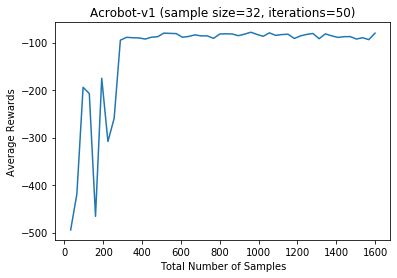

In [133]:
obj.trainModel('antithetic', 'random_Hadamard_matrices_sampling',step_size=500)

In [134]:
obj.testModel(steps=500, isSave=0, repeat_num = 30)

Finish in 90 steps
Finish in 74 steps
Finish in 223 steps
Finish in 74 steps
Finish in 194 steps
Finish in 74 steps
Finish in 83 steps
Finish in 227 steps
Finish in 98 steps
Finish in 73 steps
Finish in 82 steps
Finish in 88 steps
Finish in 74 steps
Finish in 73 steps
Finish in 90 steps
Finish in 84 steps
Finish in 66 steps
Finish in 73 steps
Finish in 73 steps
Finish in 73 steps
Finish in 73 steps
Finish in 73 steps
Finish in 89 steps
Finish in 73 steps
Finish in 74 steps
Finish in 74 steps
Finish in 90 steps
Finish in 65 steps
Finish in 96 steps
Finish in 64 steps
The rewards for 30 attemps is: [-90.0, -74.0, -223.0, -74.0, -194.0, -74.0, -83.0, -227.0, -98.0, -73.0, -82.0, -88.0, -74.0, -73.0, -90.0, -84.0, -66.0, -73.0, -73.0, -73.0, -73.0, -73.0, -89.0, -73.0, -74.0, -74.0, -90.0, -65.0, -96.0, -64.0]
The average reward for 30 attemps is: -91.9
The standard deviation for 30 attemps is: 42.089072215956485


Echo 1 completed, avg_reward -468.020000
Echo 10 completed, avg_reward -157.100000
Echo 20 completed, avg_reward -82.890000
Echo 30 completed, avg_reward -81.040000
Echo 40 completed, avg_reward -87.900000
Echo 50 completed, avg_reward -84.670000


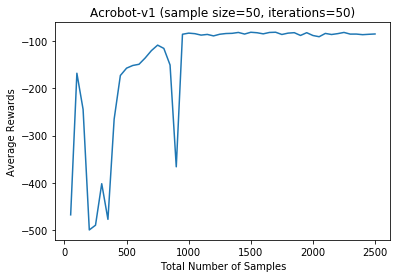

In [140]:
obj.trainModel('antithetic', 'givens_random_rotation_new', step_size=500)

In [141]:
obj.testModel(steps=500, isSave=0, repeat_num = 30)

Finish in 80 steps
Finish in 91 steps
Finish in 81 steps
Finish in 79 steps
Finish in 78 steps
Finish in 71 steps
Finish in 73 steps
Finish in 73 steps
Finish in 82 steps
Finish in 81 steps
Finish in 79 steps
Finish in 78 steps
Finish in 87 steps
Finish in 81 steps
Finish in 77 steps
Finish in 72 steps
Finish in 108 steps
Finish in 82 steps
Finish in 82 steps
Finish in 64 steps
Finish in 85 steps
Finish in 93 steps
Finish in 76 steps
Finish in 136 steps
Finish in 77 steps
Finish in 87 steps
Finish in 85 steps
Finish in 91 steps
Finish in 91 steps
Finish in 102 steps
The rewards for 30 attemps is: [-80.0, -91.0, -81.0, -79.0, -78.0, -71.0, -73.0, -73.0, -82.0, -81.0, -79.0, -78.0, -87.0, -81.0, -77.0, -72.0, -108.0, -82.0, -82.0, -64.0, -85.0, -93.0, -76.0, -136.0, -77.0, -87.0, -85.0, -91.0, -91.0, -102.0]
The average reward for 30 attemps is: -84.06666666666666
The standard deviation for 30 attemps is: 13.096903790166929
